# PyTorch and CIFAR10 data analysis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [3]:
sns.set_theme(style='white', palette='pastel')

In [4]:
DATA_DIRS = {
    'all cores': os.path.join('csv', 'fast-mnist', '2021-11-22-18-46-46-all'),
    'cores 1, 3 - no hyper': os.path.join('csv', 'fast-mnist', '2021-11-22-17-07-31-core1,3-nohyper'),
    'core 1 - hyper': os.path.join('csv', 'fast-mnist', '2021-11-22-17-31-49-core1-hyper'),
    'core 1 - no hyper': os.path.join('csv', 'fast-mnist', '2021-11-22-18-03-40-core1-nohyper'),
}

In [5]:
dfs = {}

for name, data_dir in DATA_DIRS.items():
    run_filenames = (
        {int(file.name.split('-')[1][:-4]): file.name
         for file in sorted(list(os.scandir(data_dir)), key=lambda x: x.name)
         if file.is_file() and not file.name.startswith('.')}
    )

    df = pd.concat(
        [pd.concat({num: pd.read_csv(os.path.join(data_dir, filename), index_col='epoch')}, names=['run'])
         for num, filename in list(run_filenames.items())[1:]]
    )
    
    dfs[name] = df
    
df = pd.concat(dfs)
df.index.set_names(['setup', 'run', 'epoch'], inplace=True)

## Preview of the dataframe

In [6]:
df

duration  train acc  valid acc  package_0 energy  \
setup             run epoch                                                     
all cores         1   1      4.430985   0.767094     0.9492        448.381116   
                      2      4.431980   0.963224     0.9503        438.643713   
                      3      4.510914   0.970970     0.9749        456.483695   
                      4      4.437958   0.974476     0.9666        449.629525   
                      5      4.431373   0.974993     0.9836        449.769418   
...                               ...        ...        ...               ...   
core 1 - no hyper 9   20     4.450271   0.987647     0.9912        217.009882   
                      21     4.453981   0.989283     0.9929        213.287052   
                      22     4.455213   0.990151     0.9922        212.808659   
                      23     4.450372   0.991453     0.9928        217.693473   
                      24     4.499760   0.992304     0.9936        215.059997   

                             package_1 energy  dram_0 energy  dram_1 energy  \
setup             run epoch                                                   
all cores         1   1            434.557176      34.903936      38.600554   
                      2            436.528790      34.938682      38.671545   
                      3            439.364659      35.517803      39.405441   
                      4            430.816585      34.913299      38.603797   
                      5            431.986016      34.934888      38.608403   
...                                       ...            ...            ...   
core 1 - no hyper 9   20           255.878801      20.551526      39.102286   
                      21           251.113309      19.313328      39.067862   
                      22           251.164641      19.228367      39.056753   
                      23           254.976886      21.239506      39.075298   
                      24           253.905356      19.326210      39.512326   

                             nvidia_gpu_0 energy  nvidia_gpu_1 energy  \
setup             run epoch                                             
all cores         1   1                  927.081              106.462   
                      2                  924.717              106.393   
                      3                  927.048              108.243   
                      4                  923.178              106.439   
                      5                  922.762              106.253   
...                                          ...                  ...   
core 1 - no hyper 9   20                 904.915              107.149   
                      21                 906.277              107.376   
                      22                 905.459              107.136   
                      23                 904.890              107.102   
                      24                 905.187              108.281   

                             package_0 power  package_1 power  dram_0 power  \
setup             run epoch                                                   
all cores         1   1           101.192200        98.072365      7.877241   
                      2            98.972411        98.495215      7.883313   
                      3           101.195397        97.400371      7.873749   
                      4           101.314501        97.075403      7.866973   
                      5           101.496620        97.483552      7.883535   
...                                      ...              ...           ...   
core 1 - no hyper 9   20           48.763300        57.497357      4.618040   
                      21           47.886833        56.379518      4.336194   
                      22           47.766214        56.375450      4.315925   
                      23           48.915795        57.293390      4.772524   
                      24           47.793655     

## Epoch duration

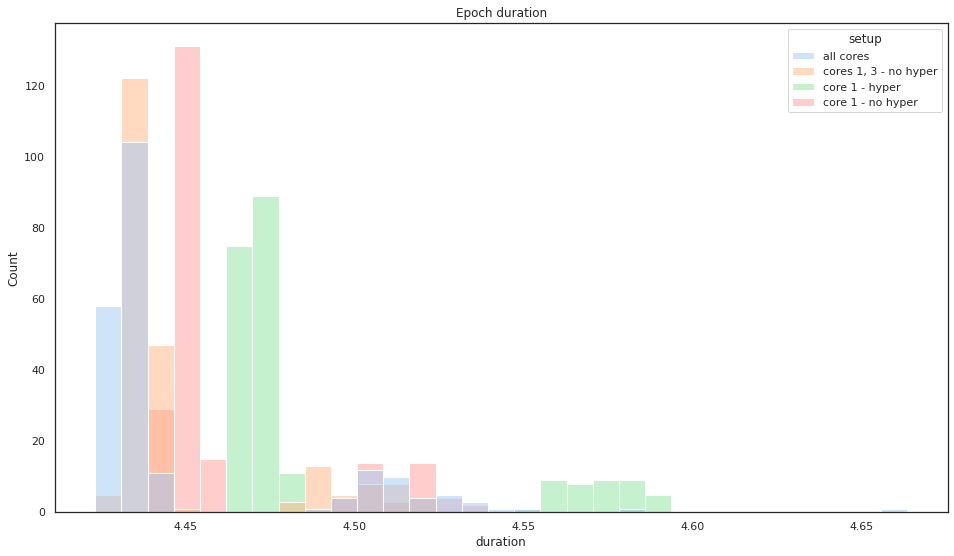

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.histplot(data=df, x='duration', hue='setup', kde=False, ax=ax)
ax.set_title('Epoch duration');

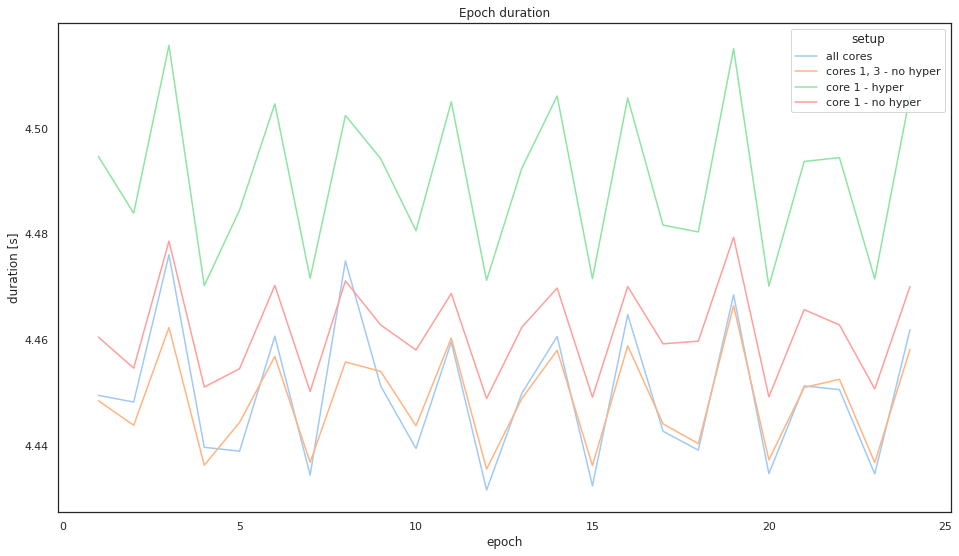

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='duration', hue='setup', ci=None, ax=ax)
ax.set_ylabel('duration [s]')
ax.set_title('Epoch duration');

## Accuracies over time

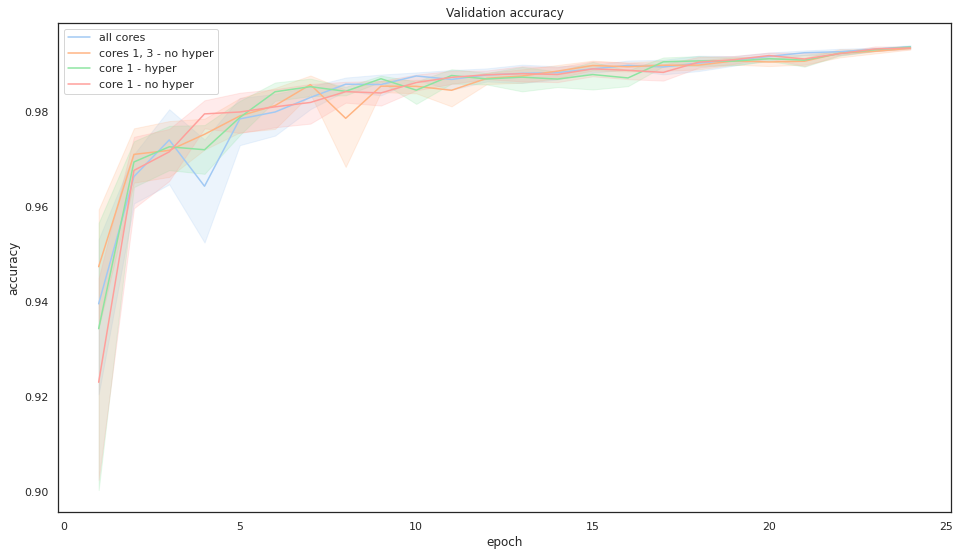

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='valid acc', hue='setup', ax=ax)
ax.set_ylabel('accuracy')
ax.set_title('Validation accuracy')
ax.legend();

## Energy consumption

In [10]:
df_sum_energy_setup = df.filter(regex='energy').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_package_energy_setup = df.filter(regex='(?=.*package)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_gpu_energy_setup = df.filter(regex='(?=.*nvidia_gpu)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')

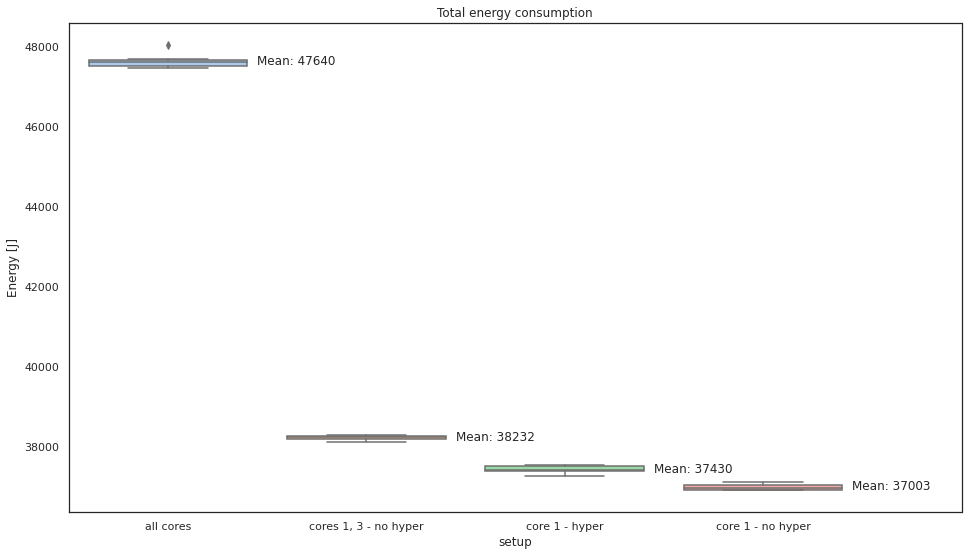

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_energy_setup, ax=ax)
ax.set_title('Total energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

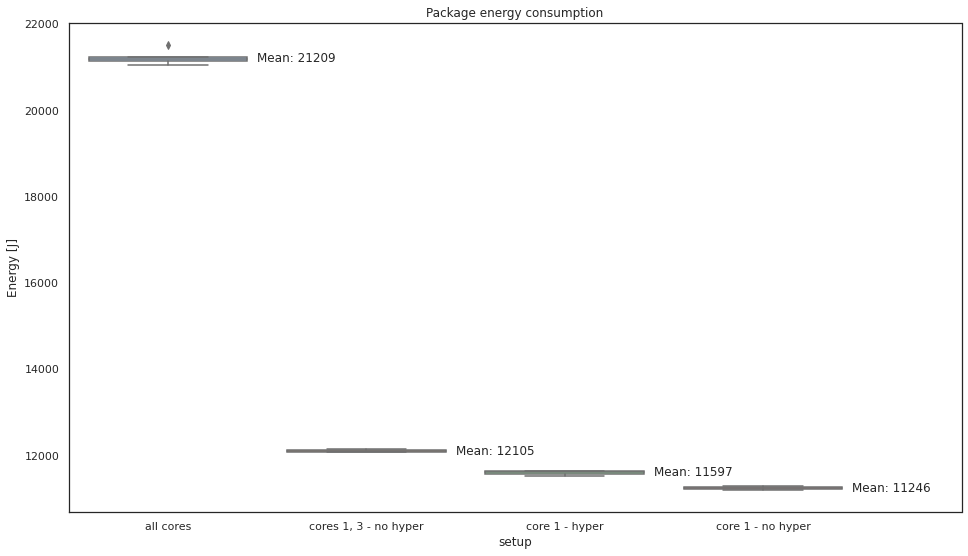

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_package_energy_setup, ax=ax)
ax.set_title('Package energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_package_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

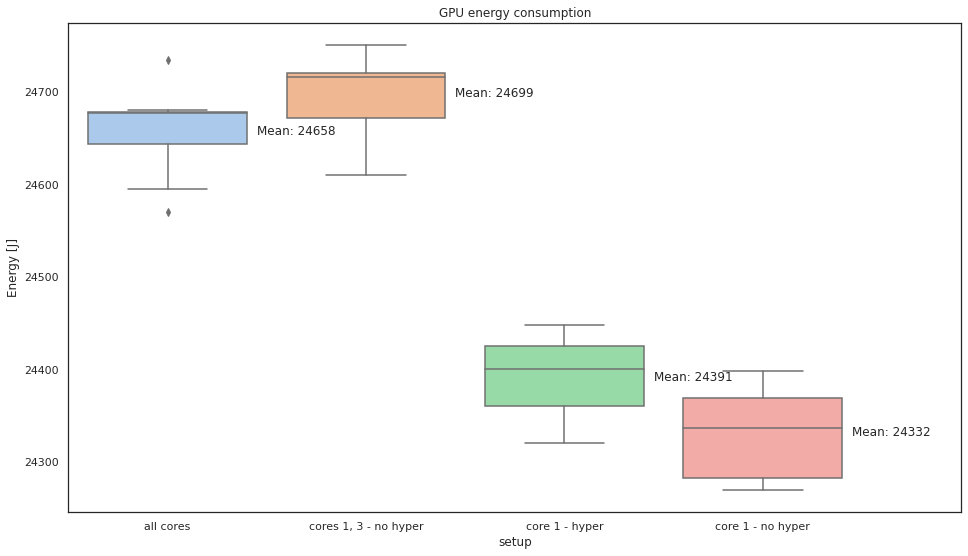

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_gpu_energy_setup, ax=ax)
ax.set_title('GPU energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_gpu_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

## Cumulative energy consumption versus accuracy

In [14]:
#df_cum_energy_validacc_run = df.filter(regex='energy').sum(axis=1)
df_cum_energy_validacc_setup = df.groupby(level=['setup', 'epoch']).mean().reset_index().set_index(['setup', 'valid acc']).filter(like='energy').sum(axis=1).unstack(level='setup').cumsum().interpolate(method='index').dropna()

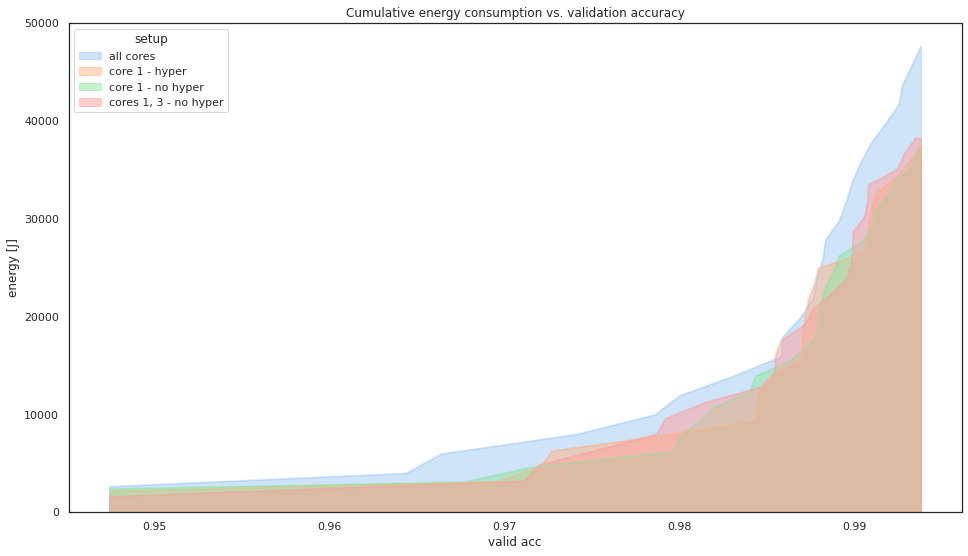

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_validacc_setup.plot.area(ylabel='energy [J]', title='Cumulative energy consumption vs. validation accuracy', stacked=False, ax=ax);

## Package power consumption

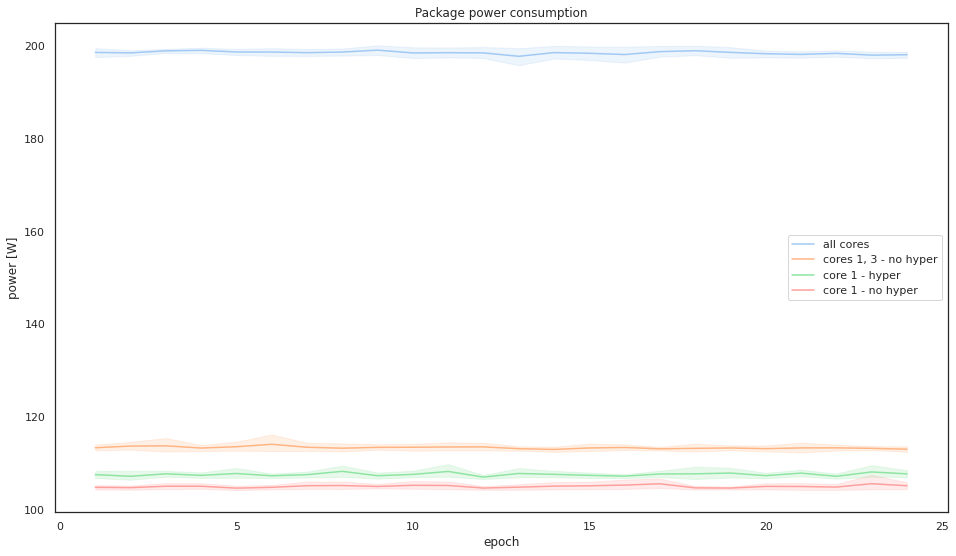

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))
df['package power'] = df['package_0 power'] + df['package_1 power']
sns.lineplot(data=df, x='epoch', y='package power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('Package power consumption')
ax.legend();

## GPU power consumption

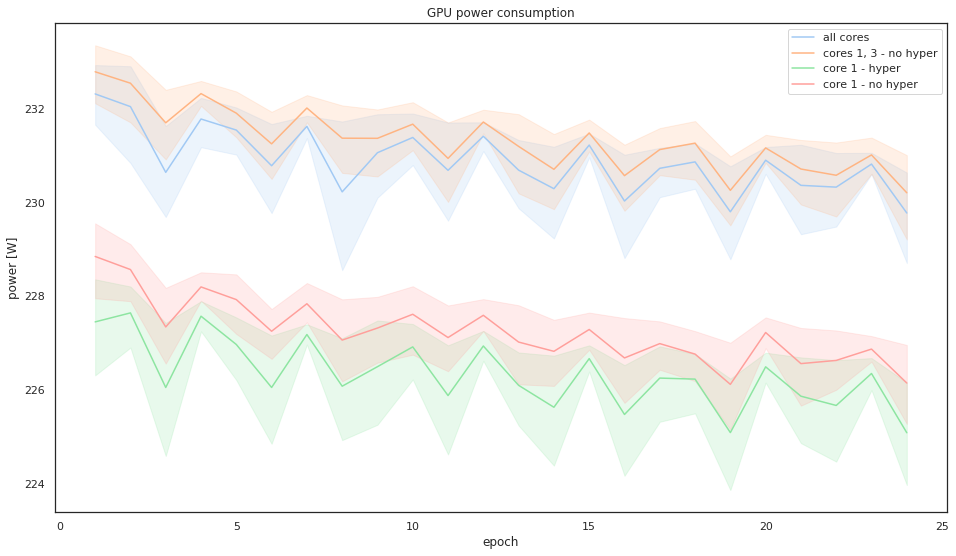

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))
df['nvidia_gpu power'] = df['nvidia_gpu_0 power'] + df['nvidia_gpu_1 power']
sns.lineplot(data=df, x='epoch', y='nvidia_gpu power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('GPU power consumption')
ax.legend();